# EathquakeDamagePred Project (PRCP- 1015)

### Data Description - 

The dataset contains the survey result of one of the largest post- disaster data ever collected by the Central Bureau of Statistics. The data contains valuable information on the impact of earthquakes, household condition, and socio-economic-demographic details. The target is to predict the level of damage to buildings caused by the earthquake.


#### Tasks:

##### Task 1:-
Prepare a complete data analysis report on the given data.

##### Task 2:- 
Create a predictive model in such a way that the objective is to predictthe ordinal variable “damage_grade”. This column presents the level of damage grade affected by the earthquake.

##### Task3:- 
Suggestions to the Seismologists to avoid earthquake event leading to significant damage in many buildings

In [13]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
!pip install category_encoders
from category_encoders import TargetEncoder

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.0 MB/s eta 0:00:00


In [14]:
# Load the data

train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')

# Merge the values and labels on building_id
data = pd.merge(train_values, train_labels, on='building_id')

# Display the first few rows
print(data.head())

# Check the shape
print(f"Dataset shape: {data.shape}")

   building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6             487           12198   
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type roof_type ground_floor_type  \
0                      t               r         n                 f   
1                      o               r         n      

In [15]:
# Basic information

print("\nData Info:")
data.info()

print("\nDescriptive Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               2606

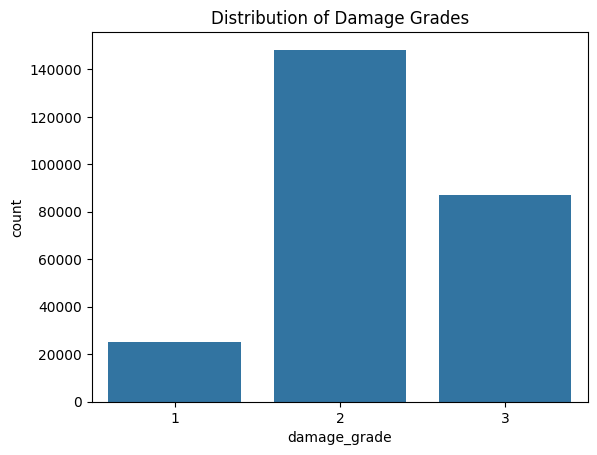


Damage Grade Counts:
damage_grade
2    0.568912
3    0.334680
1    0.096408
Name: proportion, dtype: float64


In [16]:
# Distribution of damage_grade

sns.countplot(x='damage_grade', data=data)
plt.title('Distribution of Damage Grades')
plt.show()

print("\nDamage Grade Counts:")
print(data['damage_grade'].value_counts(normalize=True))

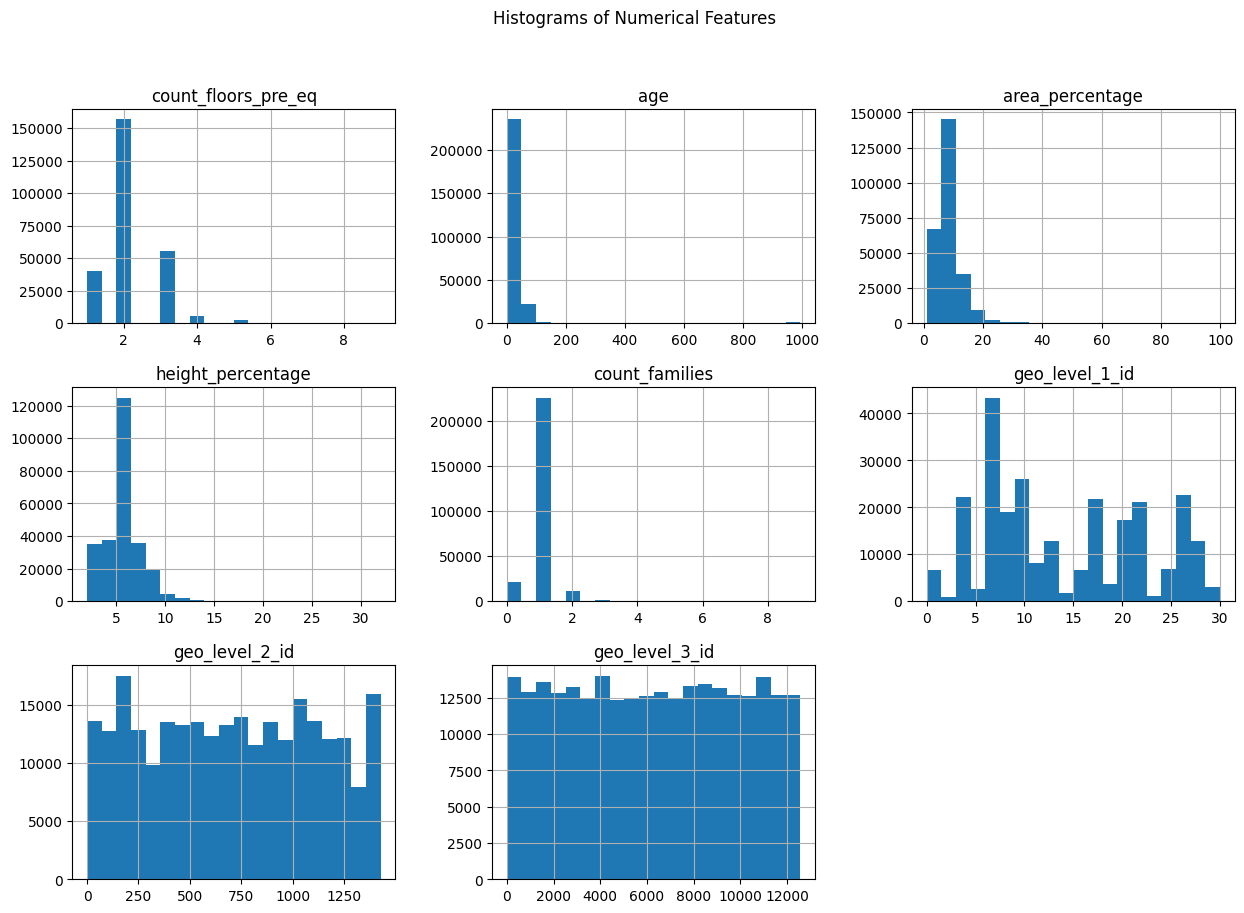

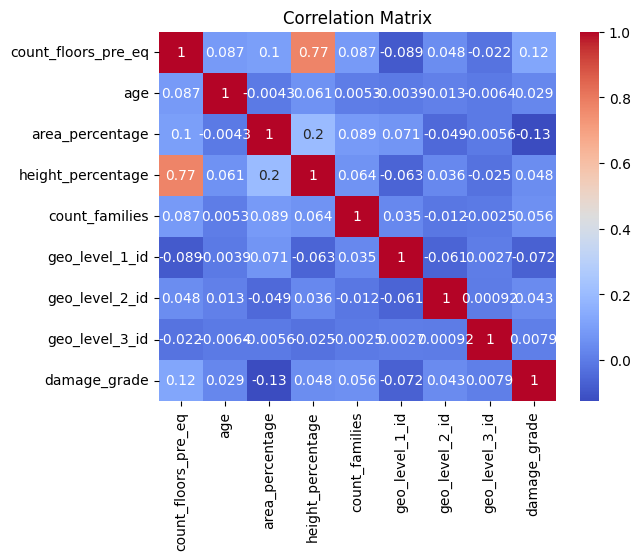

In [17]:
numerical_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families',
                  'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

# Histograms for numerical features

data[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Correlation matrix (only numerical)

corr = data[numerical_cols + ['damage_grade']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Value Counts for land_surface_condition:
land_surface_condition
t    216757
n     35528
o      8316
Name: count, dtype: int64


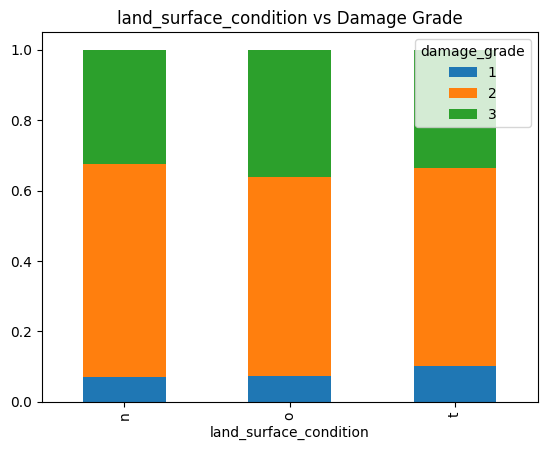


Value Counts for foundation_type:
foundation_type
r    219196
w     15118
u     14260
i     10579
h      1448
Name: count, dtype: int64


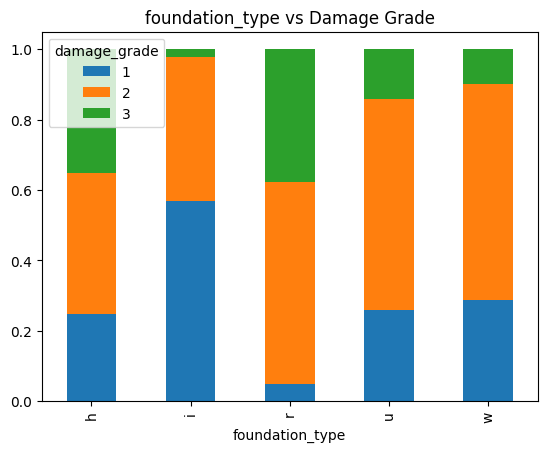


Value Counts for roof_type:
roof_type
n    182842
q     61576
x     16183
Name: count, dtype: int64


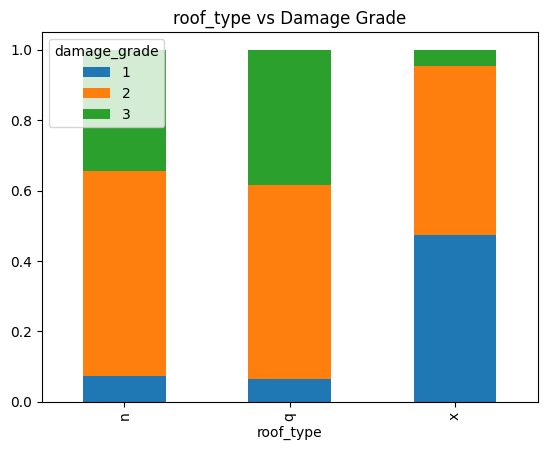


Value Counts for ground_floor_type:
ground_floor_type
f    209619
x     24877
v     24593
z      1004
m       508
Name: count, dtype: int64


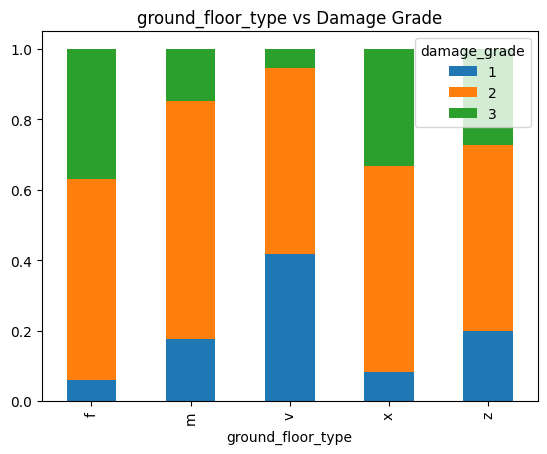


Value Counts for other_floor_type:
other_floor_type
q    165282
x     43448
j     39843
s     12028
Name: count, dtype: int64


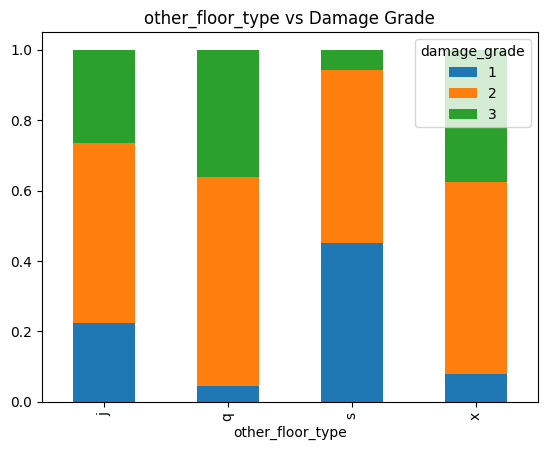

In [18]:
categorical_cols = [col for col in data.columns if data[col].dtype == 'object' or 'has_superstructure' in col or 'has_secondary_use' in col]
categorical_cols = [col for col in categorical_cols if col != 'damage_grade' and col != 'building_id']

# Value counts and crosstabs for categorical (showing first 5 for brevity)
for col in categorical_cols[:5]:
    print(f"\nValue Counts for {col}:")
    print(data[col].value_counts())

    # Crosstab with damage_grade
    crosstab = pd.crosstab(data[col], data['damage_grade'], normalize='index')
    crosstab.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Damage Grade')
    plt.show()

In [19]:
# Define features and target
X = data.drop(['building_id', 'damage_grade'], axis=1)
y = data['damage_grade']

# Improved Preprocessing: Add Target Encoding for High-Cardinality Geo Levels
geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
X[geo_cols] = X[geo_cols].astype('category')

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist() + [col for col in X.columns if 'has_' in col]
num_cols = [col for col in X.columns if col not in cat_cols]

# Optional: Log transform skewed numericals
skewed_cols = ['age', 'area_percentage', 'height_percentage']
X[skewed_cols] = np.log1p(X[skewed_cols])  # log(1 + x) to handle zeros

# Preprocessor with TargetEncoder for cats (better for high cardinality)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', TargetEncoder(), cat_cols)
    ])

# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [20]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight=class_weight_dict))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_val)
f1_lr = f1_score(y_val, y_pred_lr, average='micro')
print(f"Logistic Regression Micro F1: {f1_lr}")
print(classification_report(y_val, y_pred_lr))

Logistic Regression Micro F1: 0.680589397747549
              precision    recall  f1-score   support

           1       0.42      0.77      0.55      5025
           2       0.79      0.63      0.70     29652
           3       0.67      0.74      0.70     17444

    accuracy                           0.68     52121
   macro avg       0.63      0.71      0.65     52121
weighted avg       0.71      0.68      0.69     52121



In [21]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)
f1_rf = f1_score(y_val, y_pred_rf, average='micro')
print(f"Random Forest Micro F1: {f1_rf}")
print(classification_report(y_val, y_pred_rf))

Random Forest Micro F1: 0.7356727614589129
              precision    recall  f1-score   support

           1       0.65      0.52      0.58      5025
           2       0.75      0.82      0.78     29652
           3       0.73      0.65      0.69     17444

    accuracy                           0.74     52121
   macro avg       0.71      0.67      0.68     52121
weighted avg       0.73      0.74      0.73     52121



In [22]:
# Adjust labels to 0-2 for XGBoost

y_train_xgb = y_train - 1
y_val_xgb = y_val - 1

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])  # Class weights not directly supported; use scale_pos_weight if needed

xgb_pipeline.fit(X_train, y_train_xgb)
y_pred_xgb = xgb_pipeline.predict(X_val) + 1
f1_xgb = f1_score(y_val, y_pred_xgb, average='micro')
print(f"XGBoost Micro F1: {f1_xgb}")
print(classification_report(y_val, y_pred_xgb))

# Optional Tuning for XGBoost
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5]
}
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='f1_micro')
grid_search.fit(X_train, y_train_xgb)
print(f"Best params: {grid_search.best_params_}")
best_f1 = grid_search.best_score_
print(f"Best tuned F1: {best_f1}")

XGBoost Micro F1: 0.7405844093551543
              precision    recall  f1-score   support

           1       0.67      0.52      0.59      5025
           2       0.75      0.83      0.79     29652
           3       0.74      0.65      0.69     17444

    accuracy                           0.74     52121
   macro avg       0.72      0.67      0.69     52121
weighted avg       0.74      0.74      0.74     52121

Best params: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best tuned F1: 0.7317824185111736


In [23]:
# Subsample to 20% for speed

subsample_idx = np.random.choice(X_train.index, size=int(0.2 * len(X_train)), replace=False)
X_train_sub = X_train.loc[subsample_idx]
y_train_sub = y_train.loc[subsample_idx]

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(max_iter=2000, class_weight=class_weight_dict, random_state=42))
])

svm_pipeline.fit(X_train_sub, y_train_sub)
y_pred_svm = svm_pipeline.predict(X_val)
f1_svm = f1_score(y_val, y_pred_svm, average='micro')
print(f"SVM Micro F1: {f1_svm}")
print(classification_report(y_val, y_pred_svm))

SVM Micro F1: 0.6943842213311333
              precision    recall  f1-score   support

           1       0.49      0.59      0.54      5025
           2       0.75      0.72      0.73     29652
           3       0.68      0.68      0.68     17444

    accuracy                           0.69     52121
   macro avg       0.64      0.66      0.65     52121
weighted avg       0.70      0.69      0.70     52121



In [27]:
# Enhanced Model Evaluation

from sklearn.metrics import accuracy_score

# Calculate accuracy for each model
acc_lr = accuracy_score(y_val, y_pred_lr)
acc_rf = accuracy_score(y_val, y_pred_rf)
acc_xgb = accuracy_score(y_val, y_pred_xgb)
acc_svm = accuracy_score(y_val, y_pred_svm)
# Add acc_lgb if LightGBM results are available

# Updated comparison with accuracy
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM (Linear)'],
    'Micro F1 Score': [f1_lr, f1_rf, f1_xgb, f1_svm],
    'Accuracy': [acc_lr, acc_rf, acc_xgb, acc_svm]
})

print("\nEnhanced Model Comparison Report:")
print(models_comparison)

# Per-Class Precision and Recall Analysis
print("\nPer-Class Performance (XGBoost as Best Model):")
print(classification_report(y_val, y_pred_xgb))

# Suggestion: Focus on improving recall for grade 1 (e.g., SMOTE) if critical for seismologists.


Enhanced Model Comparison Report:
                 Model  Micro F1 Score  Accuracy
0  Logistic Regression        0.680589  0.680589
1        Random Forest        0.735673  0.735673
2              XGBoost        0.740584  0.740584
3         SVM (Linear)        0.694384  0.694384

Per-Class Performance (XGBoost as Best Model):
              precision    recall  f1-score   support

           1       0.67      0.52      0.59      5025
           2       0.75      0.83      0.79     29652
           3       0.74      0.65      0.69     17444

    accuracy                           0.74     52121
   macro avg       0.72      0.67      0.69     52121
weighted avg       0.74      0.74      0.74     52121



# Challenges Faced

#### Imbalanced Classes

Damage grades aren’t evenly distributed (often Grade 2 dominates), making models biased toward the majority class and hurting minority-grade recall.

#### Mixed Data types

Dataset has binary flags, integers, and high-cardinality IDs that require different preprocessing strategies (e.g., target encoding for IDs, scaling for numeric).

#### Data Leakage Risks

Improper encoding of geo IDs using full data before train-test split can leak target info and inflate CV scores unrealistically.